
#Project 

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. This is the project where I am build a person of interest identifier based on financial and email data made public as a result of the Enron scandal.

##Preparation


In [1]:
import sys
import pickle
import numpy
import pandas
import sklearn
from time import time
from copy import copy


#import ggplot
#from ggplot import *
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data
import enron 
import evaluate


numpy.random.seed(42)

##Create features list

In [2]:
## Create features list
features_list = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 
                 'loan_advances', 'bonus', 'restricted_stock_deferred', 
                 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 
                 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees'] 

### Load the dictionary containing the dataset
enron_data = pickle.load(open("final_project_dataset.pkl", "r") )



## Load POI names file
fpoi = open("poi_names.txt", "r")

# Print available information for Jeffrey Skilling
print enron_data["SKILLING JEFFREY K"]

{'salary': 1111258, 'to_messages': 3627, 'deferral_payments': 'NaN', 'total_payments': 8682716, 'exercised_stock_options': 19250000, 'bonus': 5600000, 'restricted_stock': 6843672, 'shared_receipt_with_poi': 2042, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 26093672, 'expenses': 29336, 'loan_advances': 'NaN', 'from_messages': 108, 'other': 22122, 'from_this_person_to_poi': 30, 'poi': True, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 1920000, 'email_address': 'jeff.skilling@enron.com', 'from_poi_to_this_person': 88}


##People in the dataset

In [3]:
people = len(enron_data)
print "There are " + str(people) + " people in the dataset."

There are 146 people in the dataset.


##Features in the dataset

In [4]:
features = len(enron_data['SKILLING JEFFREY K'])
print "There are " + str(features) + " features in the dataset."

There are 21 features in the dataset.


##poi's in the dataset

In [5]:
def poi_counter(file):
    count = 0 
    for person in file:
        if file[person]['poi'] == True:
            count += 1
    print "There are " + str(count) + " poi's in the dataset."

poi_counter(enron_data)

There are 18 poi's in the dataset.


##Total Poi

In [6]:
fpoi = open("poi_names.txt", "r")
rfile = fpoi.readlines()
poi = len(rfile[2:])
print "There were " + str(poi) + " poi's total."

There were 35 poi's total.


##Outliers
Detect and remove outliers

97343619.0


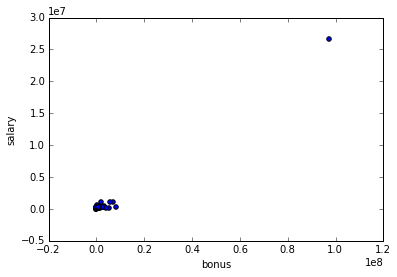

In [7]:
features = ["bonus", "salary"]
data = featureFormat(enron_data, features)


### your code below
print data.max()
for point in data:
    bonus = point[0]
    salary = point[1]
    matplotlib.pyplot.scatter( bonus, salary )

matplotlib.pyplot.xlabel("bonus")
matplotlib.pyplot.ylabel("salary")
matplotlib.pyplot.show()

Holy cow, that is a big outlier, Let see who or what is it.

In [8]:
from pprint import pprint
bonus_outliers = []
for key in enron_data:
    val = enron_data[key]['bonus']
    if val == 'NaN':
        continue
    bonus_outliers.append((key,int(val)))

pprint(sorted(bonus_outliers,key=lambda x:x[1],reverse=True)[:2])

[('TOTAL', 97343619), ('LAVORATO JOHN J', 8000000)]


In [9]:
salary_outliers = []
for key in enron_data:
    val = enron_data[key]['salary']
    if val == 'NaN':
        continue
    salary_outliers.append((key,int(val)))

pprint(sorted(salary_outliers,key=lambda x:x[1],reverse=True)[:2])

[('TOTAL', 26704229), ('SKILLING JEFFREY K', 1111258)]


**TOTAL** column as the major outlier in this dataset, Looking the the XLS we found it is the EXCEL artifact and should be removed.  Another outlier is also determined, **THE TRAVEL AGENCY IN THE PARK** this record did not represent an individual.  Both of these should be removed.

8000000.0


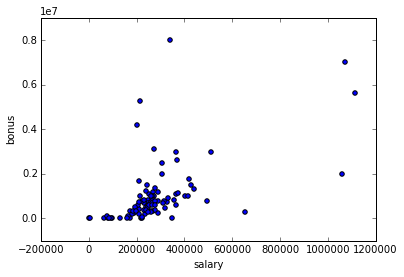

In [10]:
features = ["salary", "bonus"]

enron_data.pop('TOTAL',0)
enron_data.pop('THE TRAVEL AGENCY IN THE PARK',0)

my_dataset = copy(enron_data)
my_feature_list = copy(features_list)

data = featureFormat(enron_data, features)


### your code below
print data.max()
for point in data:
    salary = point[0]
    bonus = point[1]
    matplotlib.pyplot.scatter( salary, bonus )

matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()

since 'from_poi_to_this_person' and 'from_this_person_to_poi' are very important features too, we shoudl investigate those w.r.t. outliers and remove any outliers.

609.0


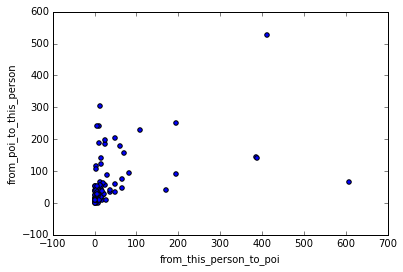

In [11]:
features = ["from_this_person_to_poi", "from_poi_to_this_person"]
data = featureFormat(enron_data, features)


### your code below
print data.max()
for point in data:
    from_this_person_to_poi = point[0]
    from_poi_to_this_person = point[1]
    matplotlib.pyplot.scatter( from_this_person_to_poi, from_poi_to_this_person )

matplotlib.pyplot.xlabel("from_this_person_to_poi")
matplotlib.pyplot.ylabel("from_poi_to_this_person")
matplotlib.pyplot.show()

Looks like few more outliers, I am going to investigate them to see if I need to include or exclude them.

In [12]:
to_poi_outliers = []
for key in enron_data:
    val = enron_data[key]['from_this_person_to_poi']
    if val == 'NaN':
        continue
    to_poi_outliers.append((key,int(val)))

pprint(sorted(to_poi_outliers,key=lambda x:x[1],reverse=True)[:2])

[('DELAINEY DAVID W', 609), ('LAVORATO JOHN J', 411)]


In [13]:
from_poi_outliers = []
for key in enron_data:
    val = enron_data[key]['from_poi_to_this_person']
    if val == 'NaN':
        continue
    from_poi_outliers.append((key,int(val)))

pprint(sorted(from_poi_outliers,key=lambda x:x[1],reverse=True)[:2])

[('LAVORATO JOHN J', 528), ('DIETRICH JANET R', 305)]


These are real people and I am going to keep them in the dataset.  I'll only be removing 'TOTAL' and 'THE TRAVEL AGENCY IN THE PARK' for my final file.

##Load data into Pandas

In [14]:
df = pandas.DataFrame.from_records(list(enron_data.values()))
persons = pandas.Series(list(enron_data.keys()))



##View of data

In [15]:
print df.head()

     bonus deferral_payments deferred_income director_fees  \
0   600000               NaN             NaN           NaN   
1  1200000           1295738        -1386055           NaN   
2   350000               NaN         -400729           NaN   
3      NaN               NaN             NaN           NaN   
4  1500000               NaN        -3117011           NaN   

              email_address exercised_stock_options expenses from_messages  \
0      mark.metts@enron.com                     NaN    94299            29   
1                       NaN                 6680544    11200           NaN   
2  steven.elliott@enron.com                 4890344    78552           NaN   
3     bill.cordes@enron.com                  651850      NaN            12   
4    kevin.hannon@enron.com                 5538001    34039            32   

  from_poi_to_this_person from_this_person_to_poi        ...         \
0                      38                       1        ...          
1               

##data types

In [16]:
df.dtypes

bonus                        object
deferral_payments            object
deferred_income              object
director_fees                object
email_address                object
exercised_stock_options      object
expenses                     object
from_messages                object
from_poi_to_this_person      object
from_this_person_to_poi      object
loan_advances                object
long_term_incentive          object
other                        object
poi                            bool
restricted_stock             object
restricted_stock_deferred    object
salary                       object
shared_receipt_with_poi      object
to_messages                  object
total_payments               object
total_stock_value            object
dtype: object

## Check and take care of "NaN"

Lot of "NaN" values let us how many per feature.

In [17]:
# Convert to numpy nan
df.replace(to_replace='NaN', value=numpy.nan, inplace=True)

# Count number of NaN's for columns
print df.isnull().sum()

# DataFrame dimeansion
print df.shape
# print df.head()

bonus                         63
deferral_payments            106
deferred_income               96
director_fees                128
email_address                 33
exercised_stock_options       43
expenses                      50
from_messages                 58
from_poi_to_this_person       58
from_this_person_to_poi       58
loan_advances                141
long_term_incentive           79
other                         53
poi                            0
restricted_stock              35
restricted_stock_deferred    127
salary                        50
shared_receipt_with_poi       58
to_messages                   58
total_payments                21
total_stock_value             19
dtype: int64
(144, 21)


Lets address the "NaN" values.

In [18]:
df_imp = df.replace(to_replace=numpy.nan, value=0)
df_imp = df.fillna(0).copy(deep=True)
df_imp.columns = list(df.columns.values)
print df_imp.isnull().sum()
print df_imp.head()

df_imp.describe()

bonus                        0
deferral_payments            0
deferred_income              0
director_fees                0
email_address                0
exercised_stock_options      0
expenses                     0
from_messages                0
from_poi_to_this_person      0
from_this_person_to_poi      0
loan_advances                0
long_term_incentive          0
other                        0
poi                          0
restricted_stock             0
restricted_stock_deferred    0
salary                       0
shared_receipt_with_poi      0
to_messages                  0
total_payments               0
total_stock_value            0
dtype: int64
     bonus  deferral_payments  deferred_income  director_fees  \
0   600000                  0                0              0   
1  1200000            1295738         -1386055              0   
2   350000                  0          -400729              0   
3        0                  0                0              0   
4  1500000 

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.00000,144.000000,144.000000,144,144.000000,144.000000,144.000000,144.000000,144.000000,1.440000e+02,144.000000
mean,675997.354167,222089.555556,-193683.270833,9980.319444,2075801.979167,35375.340278,363.583333,38.756944,24.625000,582812.50000,336957.833333,294745.534722,0.125,868536.291667,73417.902778,185446.034722,702.611111,1238.555556,2.256543e+06,2909785.611111
std,1233155.255938,754101.302578,606011.135120,31300.575144,4795513.145239,45309.303038,1450.675239,74.276769,79.778266,6794471.77894,687182.567651,1131325.452833,0.3318733,2016572.388715,1301983.390377,197042.123807,1077.290736,2237.564816,8.847189e+06,6189018.075043
min,0.000000,-102500.000000,-3504386.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,False,-2604490.000000,-1787380.000000,0.000000,0.000000,0.000000,0.000000e+00,-44093.000000
25%,0.000000,0.000000,-37086.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0,24345.000000,0.000000,0.000000,0.000000,0.000000,9.019275e+04,244326.500000
50%,300000.000000,0.000000,0.000000,0.000000,608293.500000,20182.000000,17.500000,4.000000,0.000000,0.00000,0.000000,919.000000,0,360528.000000,0.000000,210596.000000,114.000000,347.500000,9.413595e+05,965955.000000
75%,800000.000000,8535.500000,0.000000,0.000000,1683580.250000,53328.250000,53.000000,41.250000,14.000000,0.00000,374586.250000,148577.000000,0,737456.000000,0.000000,269667.500000,933.750000,1623.000000,1.945668e+06,2295175.750000
max,8000000.000000,6426990.000000,0.000000,137864.000000,34348384.000000,228763.000000,14368.000000,528.000000,609.000000,81525000.00000,5145434.000000,10359729.000000,True,14761694.000000,15456290.000000,1111258.000000,5521.000000,15149.000000,1.035598e+08,49110078.000000


##Feature Correlation:

### Try pairgrid to see what features popout more than others:

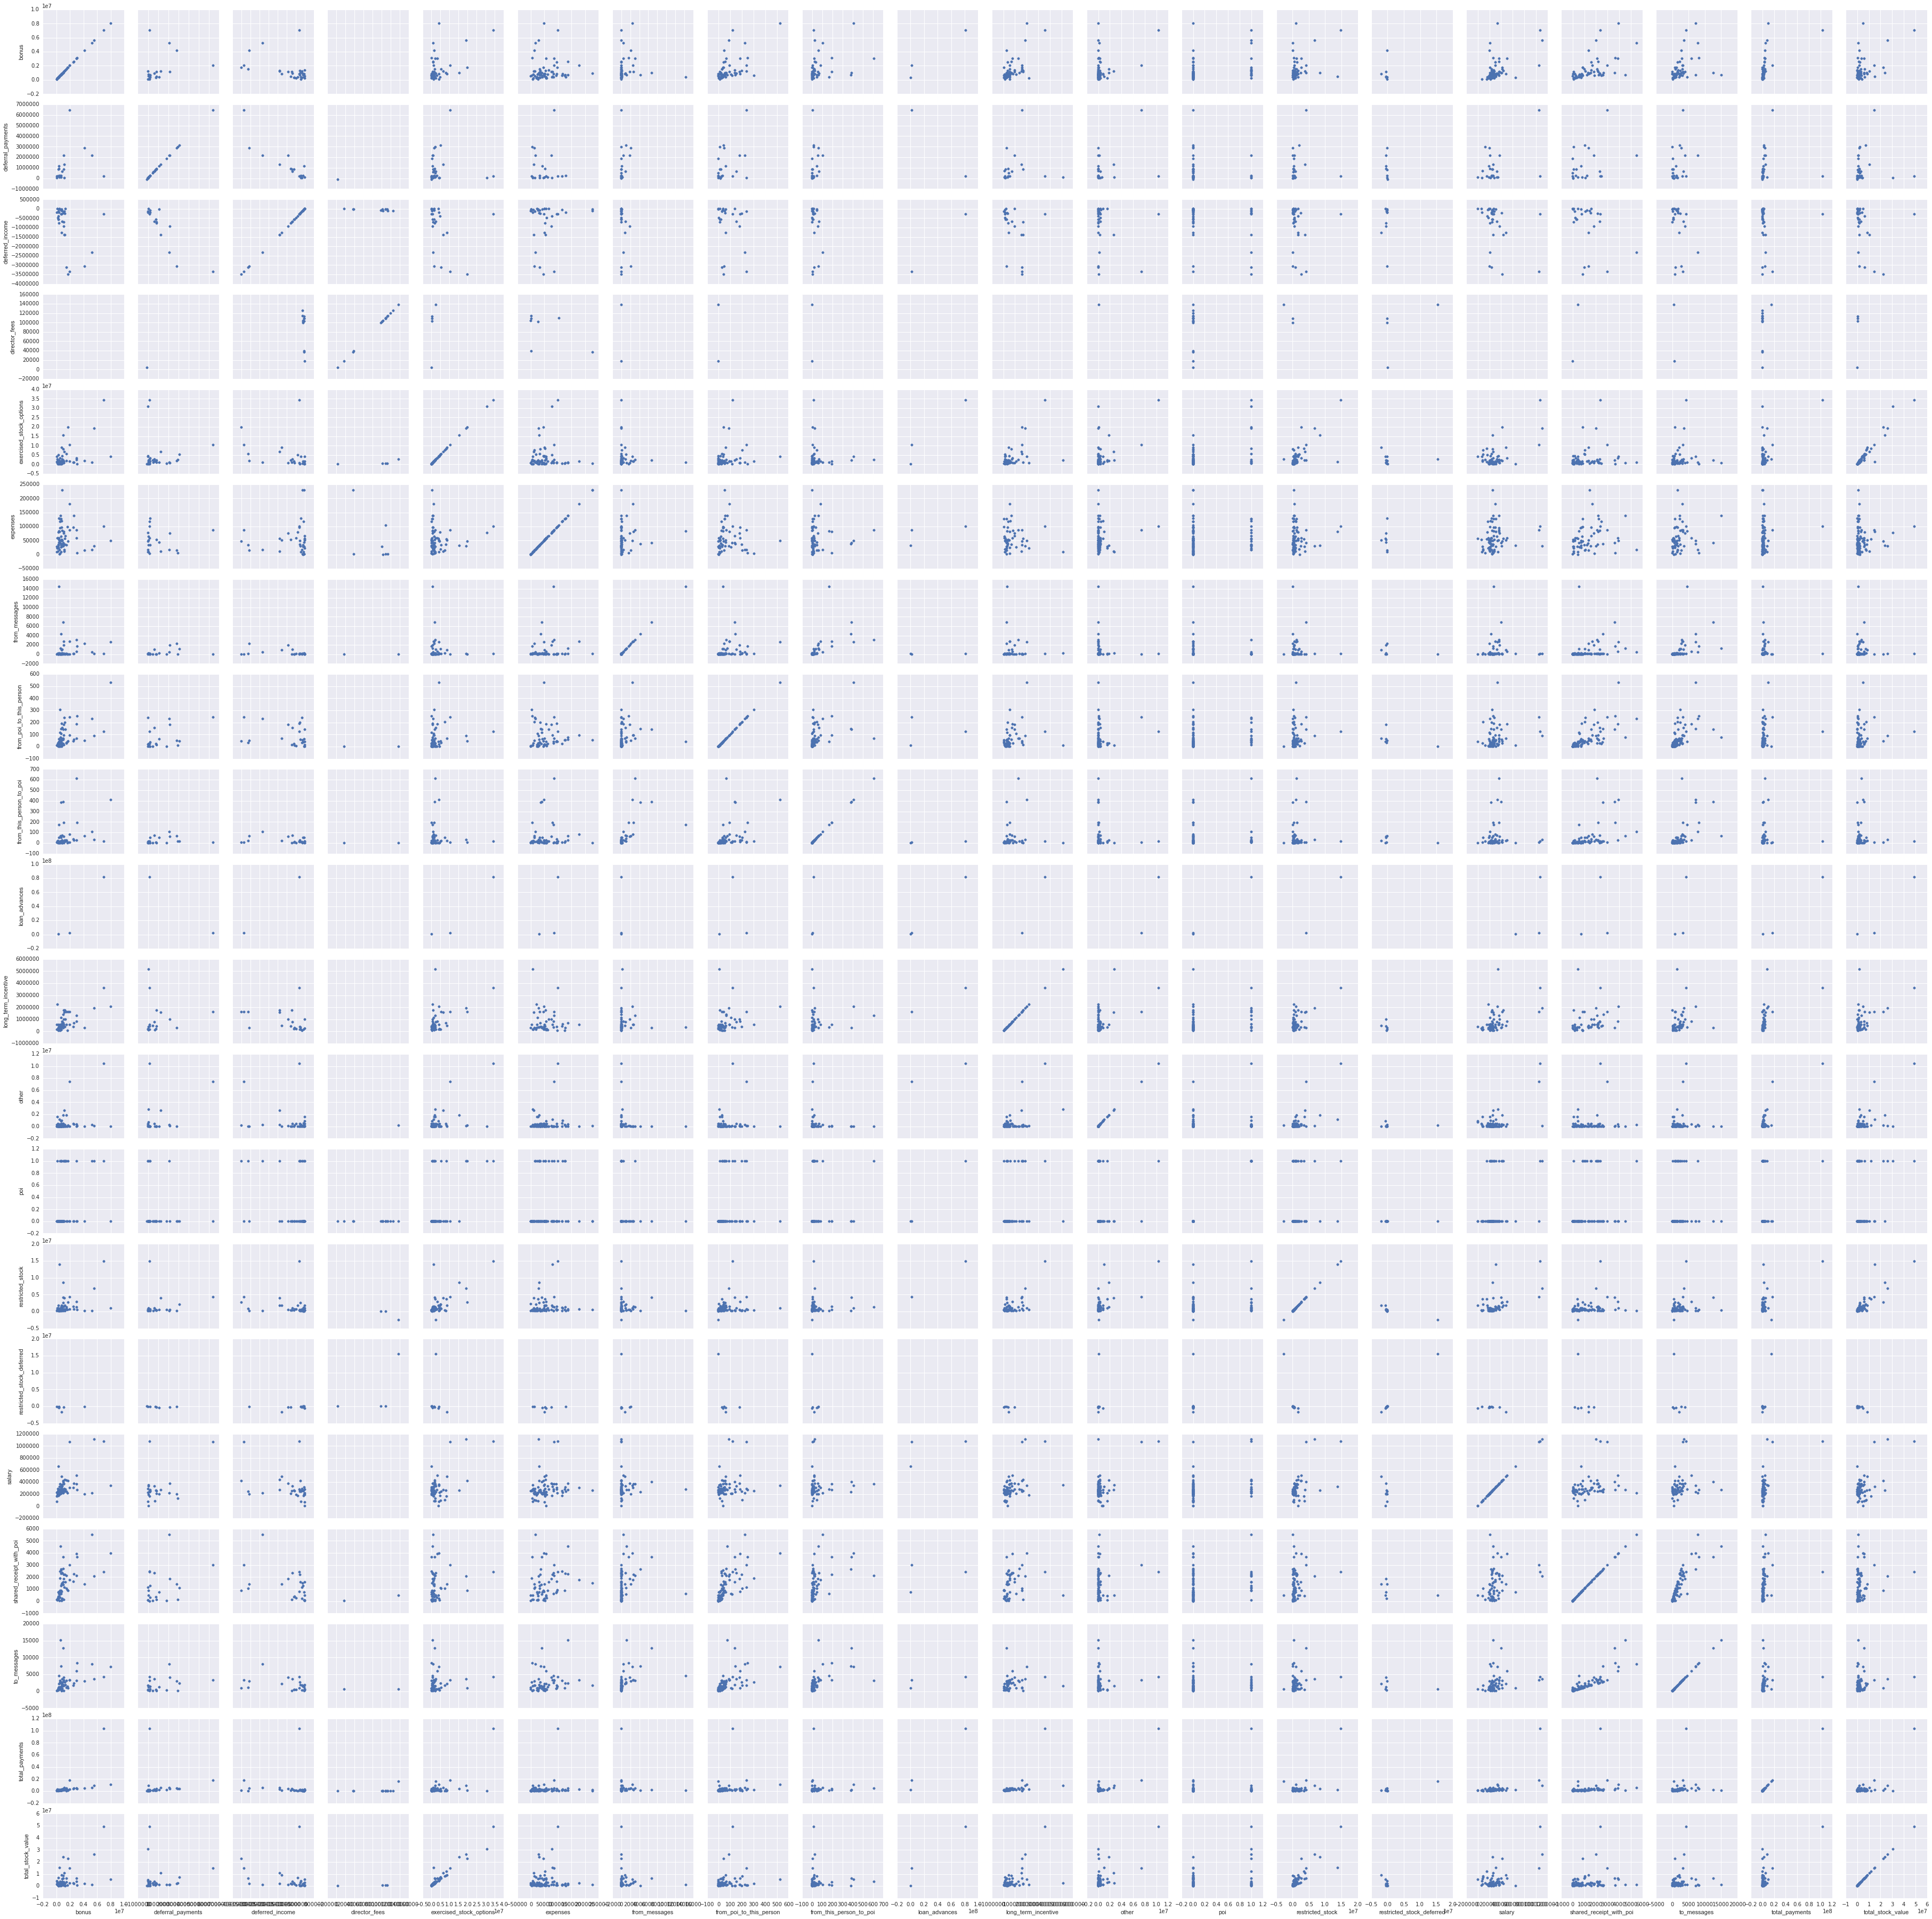

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.PairGrid(df)
g.map(plt.scatter);

Can't really see anything that will give me better clues than just looking at the feature names. Let us keep moving.

### Try heatmap to see what features popout more than others:

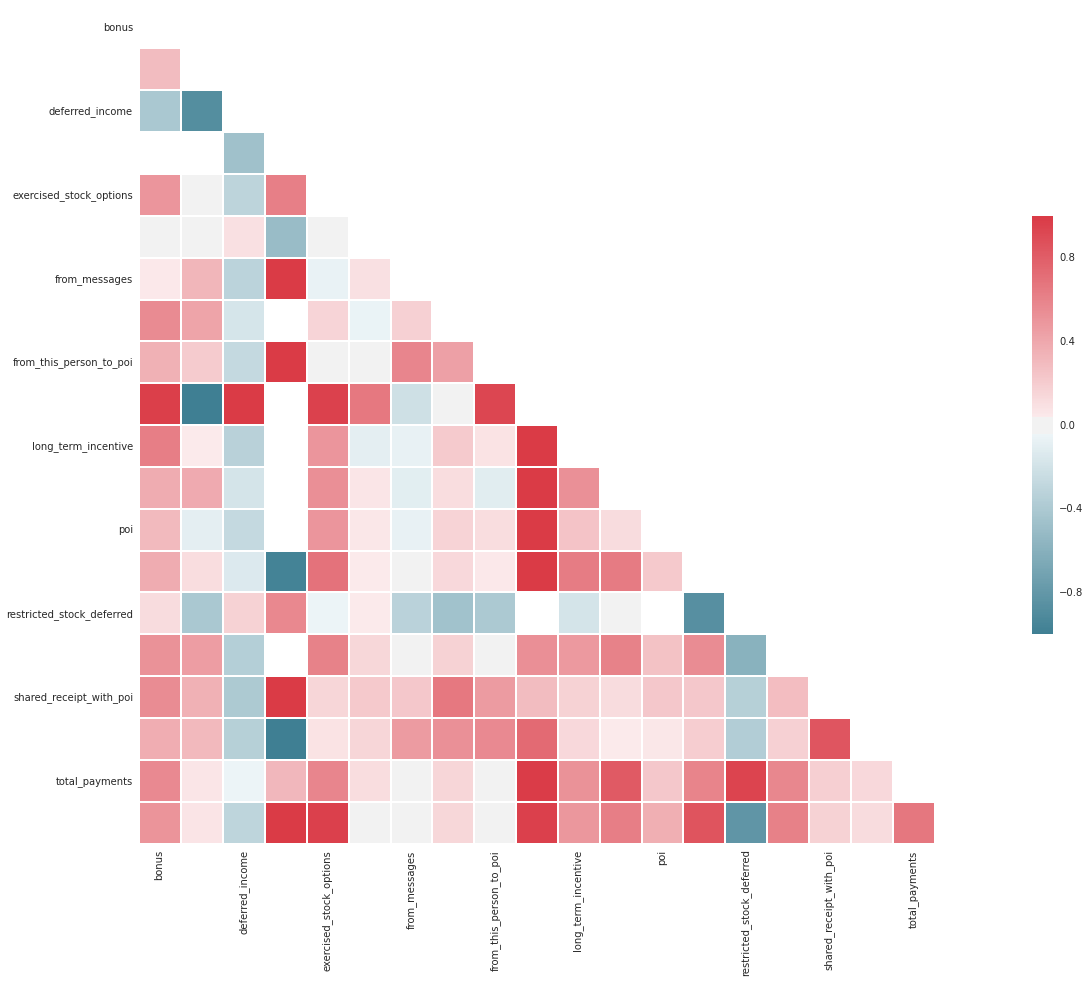

In [20]:
from string import letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



sns.set(style="white")



# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

same as pairgrid, let us continue our quest.

### Try Correlation and Corrplot to see what features popout more than others:

In [21]:
df.corr(method='pearson')

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
bonus,1.000000,0.293543,-0.411659,NaN,0.506998,0.033799,0.052725,0.562187,0.354634,0.973826,0.625259,0.376371,0.302384,0.376992,0.118222,0.523190,0.549102,0.372997,0.569054,0.509441
deferral_payments,0.293543,1.000000,-0.881500,NaN,0.019009,0.004800,0.321947,0.424101,0.206993,-1.000000,0.042448,0.385829,-0.098428,0.115088,-0.412777,0.455884,0.356696,0.310129,0.066774,0.075710
deferred_income,-0.411659,-0.881500,1.000000,-0.464837,-0.308076,0.101181,-0.319995,-0.178951,-0.271673,1.000000,-0.331715,-0.185219,-0.265698,-0.133895,0.173154,-0.353816,-0.394677,-0.350815,-0.054404,-0.298189
director_fees,NaN,NaN,-0.464837,1.000000,0.623257,-0.504631,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,-0.968483,0.575257,NaN,1.000000,-1.000000,0.317360,0.997476
exercised_stock_options,0.506998,0.019009,-0.308076,0.623257,1.000000,0.019412,-0.066129,0.160253,-0.030101,0.960259,0.500016,0.536248,0.503551,0.690935,-0.051644,0.607324,0.154333,0.079568,0.591690,0.963560
expenses,0.033799,0.004800,0.101181,-0.504631,0.019412,1.000000,0.094144,-0.059244,0.014964,0.658681,-0.100766,0.062874,0.060292,0.042896,0.040947,0.145364,0.223495,0.155070,0.109798,0.034707
from_messages,0.052725,0.321947,-0.319995,1.000000,-0.066129,0.094144,1.000000,0.186708,0.588687,-0.213768,-0.071958,-0.101686,-0.074308,0.003145,-0.326671,-0.003541,0.230855,0.475450,-0.033089,-0.036310
from_poi_to_this_person,0.562187,0.424101,-0.178951,NaN,0.160253,-0.059244,0.186708,1.000000,0.445063,0.009878,0.212538,0.111249,0.167722,0.133594,-0.455876,0.179055,0.659264,0.525667,0.154431,0.146366
from_this_person_to_poi,0.354634,0.206993,-0.271673,1.000000,-0.030101,0.014964,0.588687,0.445063,1.000000,0.934835,0.083591,-0.110335,0.112940,0.049284,-0.398550,0.021288,0.475748,0.568506,0.011556,0.001289
loan_advances,0.973826,-1.000000,1.000000,NaN,0.960259,0.658681,-0.213768,0.009878,0.934835,1.000000,1.000000,1.000000,0.999851,1.000000,NaN,0.535252,0.291501,0.739805,0.991879,0.962026


In [22]:
pearson = df.corr(method='pearson')
#print pearson
# assume target attr is the last, then remove corr with itself
corr_with_target = pearson.ix[-7][:-1]
#print pearson.ix
print corr_with_target

# correlations by the absolute value:
corr_with_target[abs(corr_with_target).argsort()[::-1]]


bonus                        0.376992
deferral_payments            0.115088
deferred_income             -0.133895
director_fees               -0.968483
exercised_stock_options      0.690935
expenses                     0.042896
from_messages                0.003145
from_poi_to_this_person      0.133594
from_this_person_to_poi      0.049284
loan_advances                1.000000
long_term_incentive          0.635172
other                        0.644357
poi                          0.224814
restricted_stock             1.000000
restricted_stock_deferred   -0.867102
salary                       0.550824
shared_receipt_with_poi      0.232660
to_messages                  0.195570
total_payments               0.595728
Name: restricted_stock, dtype: float64


loan_advances                1.000000
restricted_stock             1.000000
director_fees               -0.968483
restricted_stock_deferred   -0.867102
exercised_stock_options      0.690935
other                        0.644357
long_term_incentive          0.635172
total_payments               0.595728
salary                       0.550824
bonus                        0.376992
shared_receipt_with_poi      0.232660
poi                          0.224814
to_messages                  0.195570
deferred_income             -0.133895
from_poi_to_this_person      0.133594
deferral_payments            0.115088
from_this_person_to_poi      0.049284
expenses                     0.042896
from_messages                0.003145
Name: restricted_stock, dtype: float64

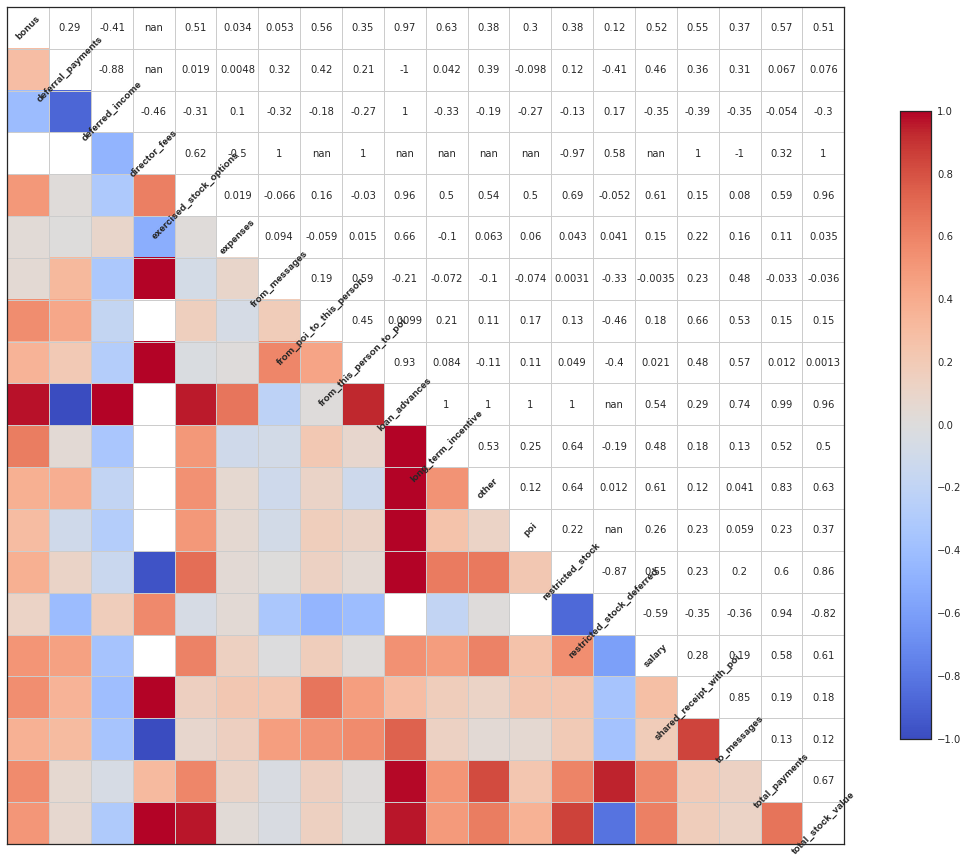

In [23]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))
sns.corrplot(df) # compute and plot the pair-wise correlations
# save to file, remove the big white borders
plt.savefig('attribute_correlations.png', tight_layout=True)

##Feature Scaling:

In [26]:
# use original features to compare with our feature selectiona d feature engineering.
eng_feature_list=features_list
print "Original Features:",features_list
print "target label & features:",eng_feature_list

data = featureFormat(enron_data, eng_feature_list)

labels, features = targetFeatureSplit(data)

# scale features via min-max
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)



Original Features: ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']
target label & features: ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']


##splitting data into training and test:

We are going to use 30% of the data as test and validation.  70% is going to be used as training.

In [27]:
features_train,features_test,labels_train,labels_test = sklearn.cross_validation.train_test_split(features,labels, test_size=0.3, random_state=42)


print labels
print features

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]
[[ 0.32916568  0.05327084  0.01569801 ...,  0.12715088  0.18366453  0.        ]
 [ 0.24036002  0.          0.21414199 ...,  0.          0.37700879  0.        ]
 [ 0.15382656  0.          0.01569801 ...,  0.          0.25295603  0.        ]
 ..., 
 [ 0.23866105  0.03518384  0.05053212

##Looking at different models

Let us iterarte through list to pick the best models.

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Extra Trees"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    ExtraTreesClassifier()]


 # iterate over classifiers
for name, clf in zip(names, classifiers):
        clf.fit(features_train,labels_train)
        scores = clf.score(features_test,labels_test)
        print " "
        print "Classifier:"
        evaluate.evaluate_clf(clf, features, labels, num_iters=1000, test_size=0.3)
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        print "====================================================================="

 
Classifier:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=3, p=2, weights='uniform')
precision: 0.257956782107
recall:    0.113278571429
Accuracy: 0.84 (+/- 0.00)
 
Classifier:
SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.0, kernel='linear', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)
precision: 0.0
recall:    0.0
Accuracy: 0.84 (+/- 0.00)
 
Classifier:
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=2,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
precision: 0.0065
recall:    0.00152619047619
Accuracy: 0.84 (+/- 0.00)
 
Classifier:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
        

The model I am picking DecisionTreeClassifier.
Let us use the grid_search.GridSearchCV to tune these models

###Model tuning using grid_search.GridSearchCV

#### define cv and scoring

In [29]:
from sklearn import grid_search
from sklearn.tree import DecisionTreeClassifier

cv = sklearn.cross_validation.StratifiedShuffleSplit(labels, n_iter=10)
def scoring(estimator, features_test, labels_test):
     labels_pred = estimator.predict(features_test)
     p = sklearn.metrics.precision_score(labels_test, labels_pred, average='micro')
     r = sklearn.metrics.recall_score(labels_test, labels_pred, average='micro')
     if p > 0.3 and r > 0.3:
            return sklearn.metrics.f1_score(labels_test, labels_pred, average='macro')
     return 0


###DecisionTreeClassifier tunning

In [30]:
t0 = time()
parameters = {'max_depth': [1,2,3,4,5,6,8,9,10],'min_samples_split':[1,2,3,4,5],'min_samples_leaf':[1,2,3,4,5,6,7,8], 'criterion':('gini', 'entropy')}

dtc_clf = sklearn.tree.DecisionTreeClassifier() 
dtcclf = grid_search.GridSearchCV(dtc_clf, parameters, scoring = scoring, cv = cv)

dtcclf.fit(features, labels)
print dtcclf.best_estimator_
print dtcclf.best_score_
print 'Processing time:',round(time()-t0,3) ,'s'


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
0.483333333333
Processing time: 14.975 s


##Classifier validation

### DecisionTreeClassifier  Validation 1 (StratifiedShuffleSplit, folds = 1000)

In [31]:
t0 = time()
dtc_best_clf = dtcclf.best_estimator_
   
test_classifier(dtc_best_clf, enron_data, eng_feature_list)

print 'Processing time:',round(time()-t0,3) ,'s'

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
	Accuracy: 0.84653	Precision: 0.36915	Recall: 0.21300	F1: 0.27013	F2: 0.23269
	Total predictions: 15000	True positives:  426	False positives:  728	False negatives: 1574	True negatives: 12272

Processing time: 0.723 s


###DecisionTreeClassifier Validation 2 (Randomized, partitioned trials, n=1,000)

In [32]:
t0 = time()
dtc_best_clf = dtcclf.best_estimator_
   
evaluate.evaluate_clf(dtc_best_clf, features, labels, num_iters=1000, test_size=0.3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print 'Processing time:',round(time()-t0,3) ,'s'

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
precision: 0.218250767288
recall:    0.21068968254
Accuracy: 0.88 (+/- 0.00)
Processing time: 1.464 s


## Feature Importance

In [57]:
from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import SelectKBest

eng_feature_list=features_list
print "Original Features:",features_list

data = featureFormat(enron_data, eng_feature_list)

labels, features = targetFeatureSplit(data)

fi_clf = DecisionTreeClassifier(random_state=0)
cross_val_score(fi_clf, features,labels, cv=10)

def get_k_best(enron_data, features_list, k):
    """ runs scikit-learn's SelectKBest feature selection
        returns dict where keys=features, values=scores
    """
    data = featureFormat(enron_data, features_list)
    labels, features = targetFeatureSplit(data)

    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    unsorted_pairs = zip(features_list[1:], scores)
   
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    print(' ')
    print("Sorted KBest:")
    print(sorted_pairs)
    print(' ')
    k_best_features = dict(sorted_pairs[:k])
    print "{0} best features: {1}\n".format(k, k_best_features.keys())
    #print k_best_features
    return k_best_features


target_label = 'poi'
from sklearn.feature_selection import SelectKBest
num_features = 18 # 10 best features
best_features = get_k_best(enron_data, features_list, num_features)
print best_features

Original Features: ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']
 
Sorted KBest:
[('exercised_stock_options', 24.815079733218194), ('total_stock_value', 24.182898678566879), ('bonus', 20.792252047181535), ('salary', 18.289684043404513), ('deferred_income', 11.458476579280369), ('long_term_incentive', 9.9221860131898225), ('restricted_stock', 9.2128106219771002), ('total_payments', 8.7727777300916792), ('shared_receipt_with_poi', 8.589420731682381), ('loan_advances', 7.1840556582887247), ('expenses', 6.0941733106389453), ('from_poi_to_this_person', 5.2434497133749582), ('other', 4.1874775069953749), ('from_this_person_to_poi', 2.3826121082276739), ('director_fees', 

In [63]:
print df.notnull().sum()

bonus                         81
deferral_payments             38
deferred_income               48
director_fees                 16
email_address                111
exercised_stock_options      101
expenses                      94
from_messages                 86
from_poi_to_this_person       86
from_this_person_to_poi       86
loan_advances                  3
long_term_incentive           65
other                         91
poi                          144
restricted_stock             109
restricted_stock_deferred     17
salary                        94
shared_receipt_with_poi       86
to_messages                   86
total_payments               123
total_stock_value            125
dtype: int64
